
# The problem: Classifying vowels from formant values using k-NN algorithm
Acoustically speaking linguists define vowels in terms of the formant values where the first and the second formants (F1, and F2) are inversely corrleated with a vowel's height and frontness, respectively. For relatively simple vowel inventory, vowel classes are assumed to have different combinations of F1 and F2 values; therefore, it is assumed that F1 and F2 only can act at the primary features that distinguish the vowel categories. A more complex vowel system may exploit the third formant (F3) as well where F3 primarily indicates the roundedness of a vowel; F3 is considered an important feature when there is a rounding contrast between two vowel that have similar F1 and F2 values.

Here is an example of a traditional 2-dimensional vowel plot using F1 and F2 (the words refer to the qualities of the vowel they contain); notice that the x- and y-axes are reversed. 

<div>
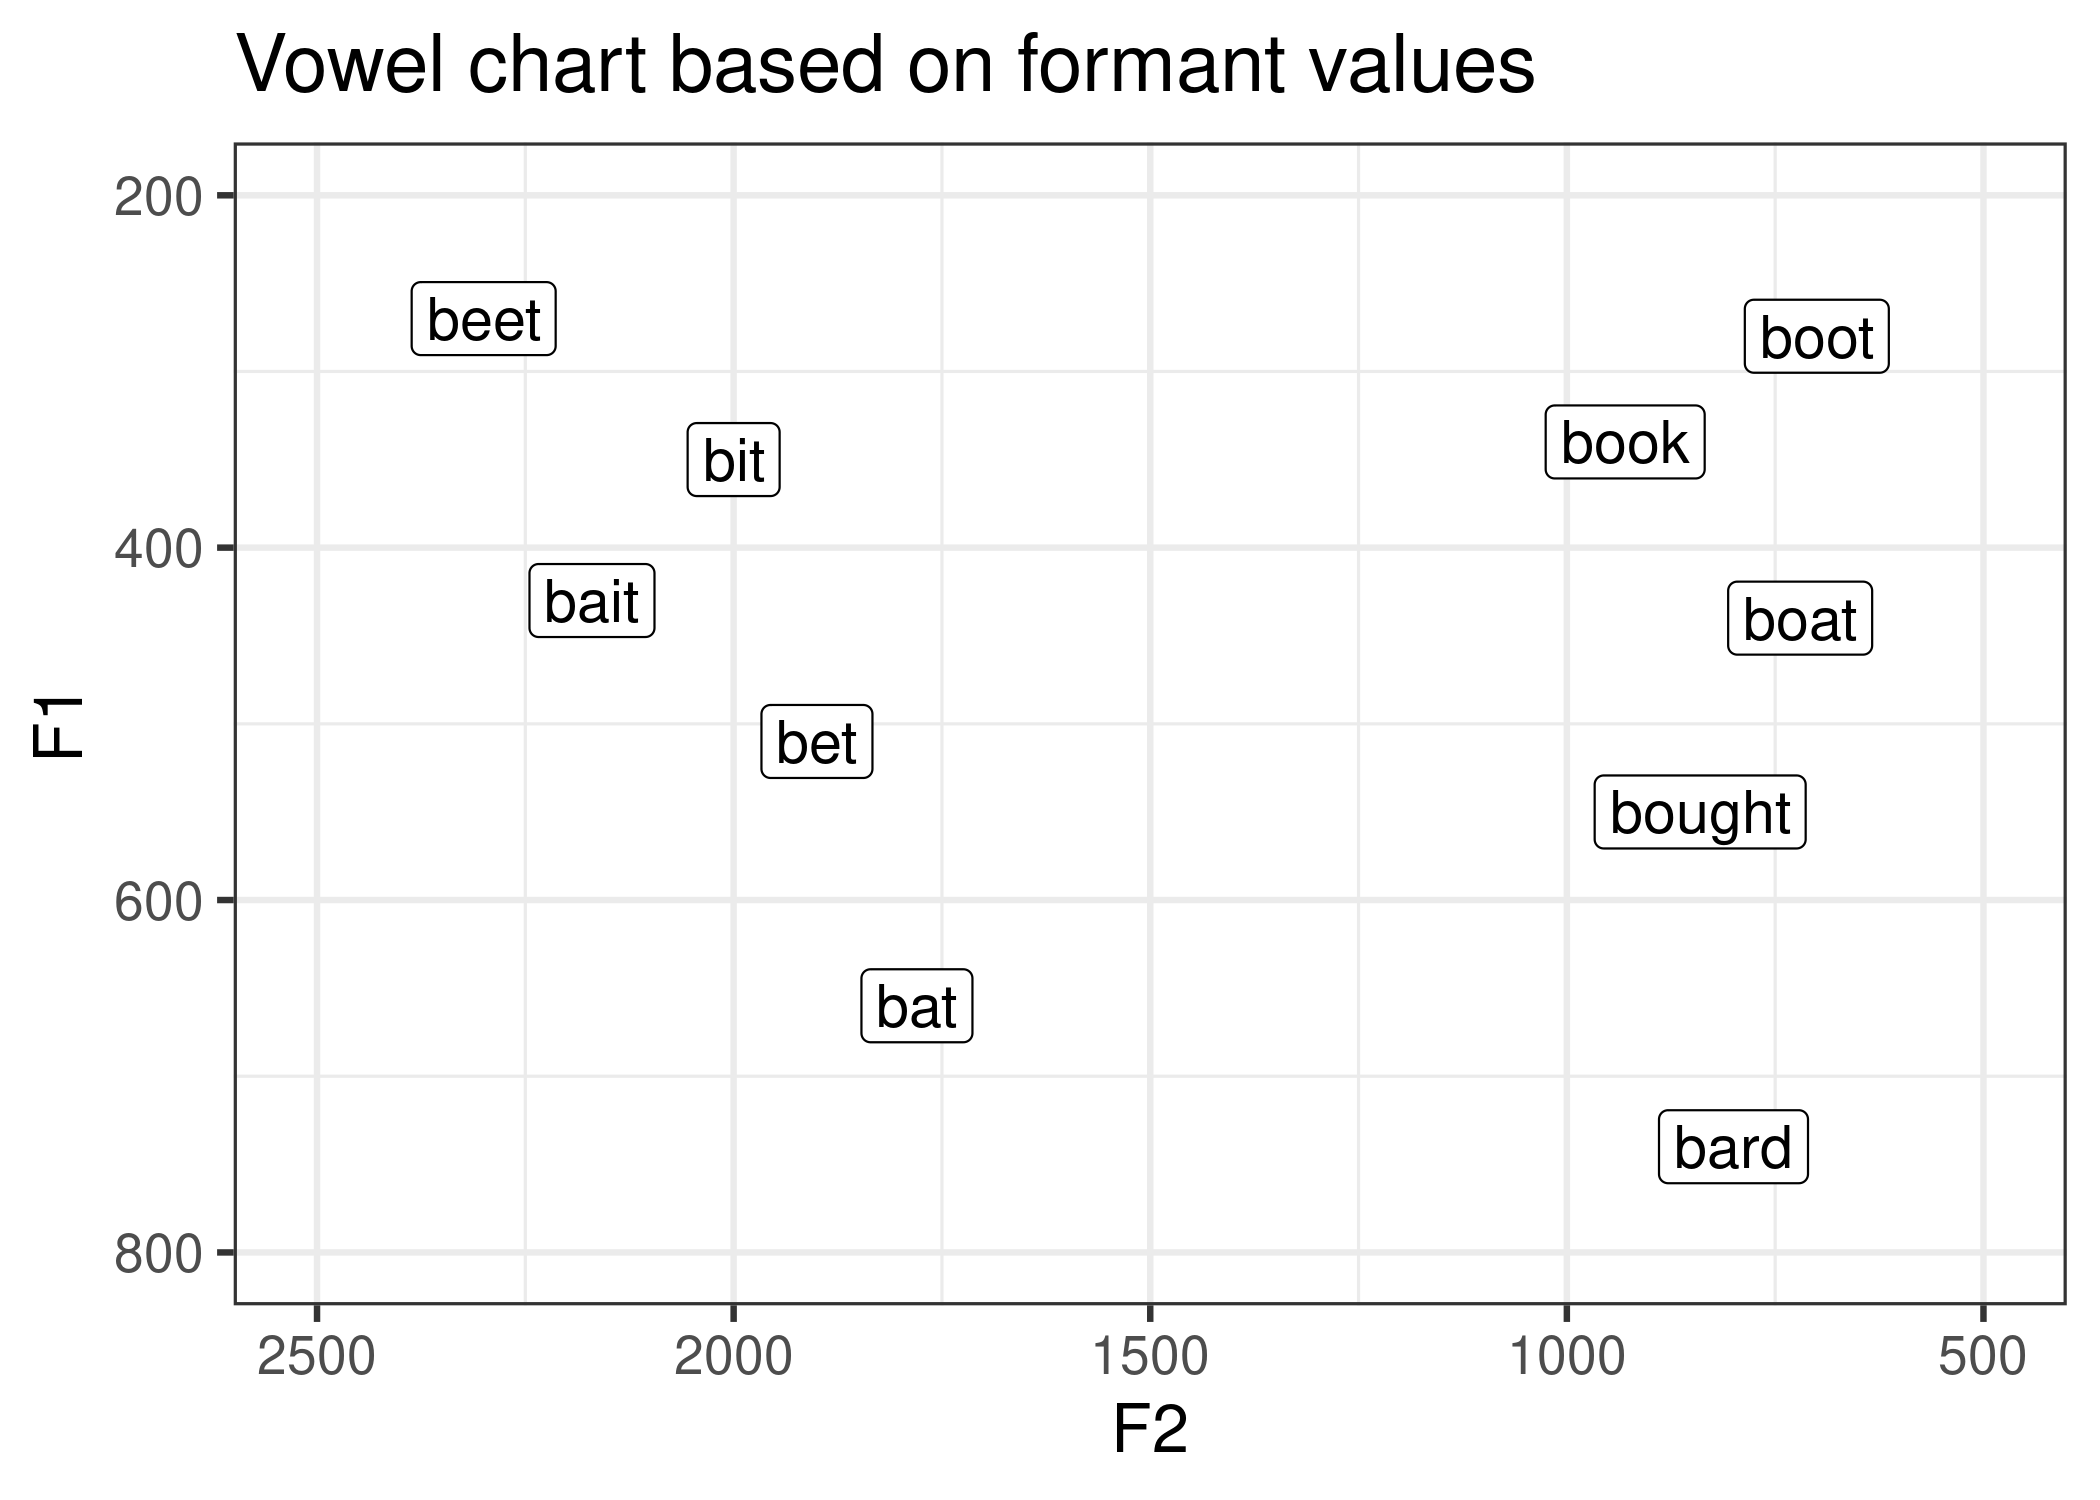
</div>


In this project, we will attempt to classify some English vowels based on their formant values (primarily F1 and F2). We'll use the k-Nearest Neighbor (k-NN) algorithm. (While we could use many other algorithms for the task, our aim is to practice k-NN here.) In fact, we'll built our own k-NN classifier from scratch using elementary Python functionality since our purpose is the build an intuitive understanding of the k-NN algorithm. Later, we'll compare our implementation to the sklearn implementation by using `sklearn.neighbors.KNeighborsClassifier`.


### The dataset
Here are some quick information about the dataset we'll use here: 
+ vowel formants exatracted from continuous speech
+ the source of the speech is [Buckeye Speech Corpus](https://buckeyecorpus.osu.edu/php/speech.php)
+ we chose to include five vowels: 'iy', 'eh', 'aa', 'ao', 'uw' (as in the words beet, bet, bard, bought, boot, respecitvely)
+ vowels that are 80 ms or longer were included
+ F1 and F2 are lobanov normalized (from raw formant frequencies)
+ the data were stored in pickle format, as lists of dictionaries



### Our tasks

Our tasks include:

1. Reading the data in pickle format
1. Implementing distance functions for k-NN
1. Establishing a baseline classifier (we'll use a majority classifier)
1. Implementing the k-NN classifier 
1. Tuning the k parameter for kiNN
1. Comparing our implementation to sklearn's method
1. Evaluating performance

In [1]:
# load libraries
import numpy as np
import pandas as pd
import pickle
import sklearn.metrics
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.dummy

## Reading data

Our dataset contains formant values for five different English vowels: IY, EH, AA, AO, UW. The formant measurements were obtained from the speech files in the [Buckeye Corpus](https://buckeyecorpus.osu.edu/); we are, however, using a small subset of the data here. 

The data is stored in a CSV file; so, we'll first read the data using pandas library and then preprocess it for machine learning. 

In [4]:
# load pickle data
with open("vowels.pkl", 'br') as f:
    data_l = pickle.load(f)
    
# inspect the first five records; note that it's a list of dictionaries   
data_l[0:5]

[{'vowel': 'iy', 'F1': -0.57, 'F2': -0.52},
 {'vowel': 'ao', 'F1': 1.13, 'F2': -1.51},
 {'vowel': 'aa', 'F1': 0.58, 'F2': -1.15},
 {'vowel': 'ao', 'F1': 1.38, 'F2': -1.09},
 {'vowel': 'iy', 'F1': -1.48, 'F2': -1.31}]

#### Create train, dev and test data
The dataset contains a total of 35167 records; however, we are going to use only 5000 records for our task here (just to keep the processing time short; you are welcome to try the whole dataset later). 

In [6]:
# separate training, development and test data 
dev = data_l[0:300]
test = data_l[300:600]
train = data_l[600:5000]

# an example record from the training data
print(train[0])

{'vowel': 'aa', 'F1': 2.89, 'F2': -0.78}


The examples in `train`, `dev` and `test` are Python dictionaries in the following format:
    
```
{'vowel': 'eh', 'f1': 0.76, 'f2': -0.05}
```

Each example contains a `"vowel"` field which tells you the true vowel corresponding to this example. The examples also contain two formant frequencies `"F1"` and `"F2"`. Our task is to build a classifier which can classify examples by vowel based on their formant frequencies.

We will now write some data preprocessing code. The aim is to convert examples in dictionary format to an input tuple and output label:

```
input: (0.76, -0.05), output: 0
```

The first value in the tuple represents the F1 formant and the second one represents the F2 formant. The output is a numerical code representing the vowel (e.g. "eh").

We'll use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to convert your vowel labels to numerical labels. 

We'll start by initializing the label encoder and then  call the `fit()` function of the label encoder on a list containing all the vowel labels (e.g. `"eh"`) to train the label encoder. Finally, we'll store the labels for the train set in a list `train_y`, for the development set in `dev_y` and for the test set in `test_y`.

We'll store the input examples (e.g. `(0.76, -0.05)`) in the lists `train_X`, `dev_X`, `test_X`.

In [12]:
# convert vowel labels to numerical values 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = [ex["vowel"] for ex in train]
dev_labels = [ex["vowel"] for ex in dev]
test_labels = [ex["vowel"] for ex in test]

label_encoder.fit(train_labels + dev_labels + test_labels)
print(label_encoder.classes_)
print(label_encoder.transform(['eh', 'aa', 'uw', 'ao', 'iy'])) # test the encoder

# create X and y for train, dev, and test
def get_X_and_y(data):
    X = []
    y = []
    for ex in data:
        f1 = ex['F1']
        f2 = ex['F2']
        X.append((f1, f2))
        label = label_encoder.transform([ex["vowel"]])[0]
        y.append(label)
    return X, y

train_X, train_y = get_X_and_y(train)
dev_X, dev_y = get_X_and_y(dev)
test_X, test_y = get_X_and_y(test)
print(train_X[0])
print(train_y[0])

['aa' 'ao' 'eh' 'iy' 'uw']
[2 0 4 1 3]
(2.89, -0.78)
0


How many classes does the dataset contain? We can check this by printing the length of the list `label_encoder._classes`

In [13]:
print(label_encoder.classes_)
print(len(label_encoder.classes_))

['aa' 'ao' 'eh' 'iy' 'uw']
5


#### Make a plot

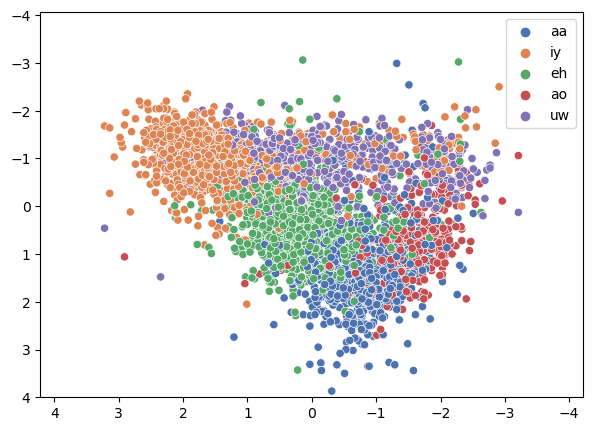

In [33]:
# make a scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

f1 = [ex[0] for ex in train_X]
f2 = [ex[1] for ex in train_X]

plt.figure(figsize=(7,5))
sns.scatterplot(x = f2, y = f1, hue = train_labels, palette = "deep")
plt.xlim(max(f2)+1, min(f2)-1) # reverse the axis 
plt.ylim(4, min(f1)-1) # reverse the axis (we also removed some points to make the plot a little more salient)
plt.show()

## Distance functions 

We would now implement two distance functions `euclidean_dist()` and `manhattan_dist()`. Both take two lists of numbers `x1` and `x2` as input and return their Euclidean and Mahattan distance, respectively. E.g.

```
euclidean_dist((1,2,3,4), (2,3,4,5)) == 2
```

We could rely on some library implementations of these functions; but here we implement them ourselves.

In [15]:
# import libraries
import math

# define function to get euclidean distance
def euclidean_dist(a, b):
    x = 0
    for i in range(len(a)):
        x += (a[i] - b[i])**2
    return (math.sqrt(x))

print(euclidean_dist((1,2,3,4), (2,3,4,5)))

# define function to get manhattan distance
def manhattan_dist(a, b):
    x = 0
    for i in range(len(a)):
        x += (a[i] - b[i])
    return (abs(x))

print(manhattan_dist((1,2,3,4), (2,3,4,5)))

2.0
4


## Majority baseline

Next, we'll implement a majority baseline and evaluate it on the development data. We'll use [`sklearn.dummy.DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) for this purpose.

In [16]:
# initiate the basiline classifier
baseline = sklearn.dummy.DummyClassifier(strategy = "most_frequent")

# fit the data with the classifier function
baseline.fit(train_X, train_y)

# test the predictions of the baseline classifier on the DEV data
baseline.score(dev_X, dev_y)

0.31

Thus, our majority classifier gives an accuracy of 31%; our k-NN classifier should work better than this. 

## KNN classifier

We'll now implement a function `knn_classify_ex` which takes the following parameters:

* `x` an example like `(0.76, -0.05)`
* `train_X` and `train_y` are the training examples (inputs and classes)
* `k` represents the k parameter for the k-NN algorithm
* dist_func is either your Euclidean distance function `euclidean_dist` or Manhattan distance function `manhattan_dist`.

The function `knn_classify_ex` finds the `k` datapoints in `train_X` which are closest to `x`. It then finds their classes and returns the majority class. E.g. if `k == 3` and among the 3 closest points to x there are 2 examples with class `0` and one with class `1`, then you should return 0. 

Importantly, we need to make sure that the function returns a single class number. Especially for smaller values of `k`, ties can easily happen and there might not exist a clear majority class. In this case, we'll return an arbitrary class chosen among the most frequent classes. 

In [17]:
from collections import Counter
# function to classify a single example
def knn_classify_ex(x, train_X, train_y, k = 1, dist_func = 'euclidean_dist'): 
    
    dist_class_pairs = []
    
    for i, ex in enumerate(train_X):
        if dist_func == 'euclidean_dist':
            d = euclidean_dist(x, ex)
        elif dist_func == 'manhattan_dist':
            d = manhattan_dist(x, ex)
        label = train_y[i]
        dist_class_pairs.append((d, label)) # store as tuples containing distance--label pairs

    # sort in ascending order (based on distance)
    dist_class_pairs.sort() 
    
    # retain only k values with the lowest distance
    k_neighbors = dist_class_pairs[0:k] 
    
    # get most common classes among k-neighbors (majority voting)
    k_classes = [x[1] for x in k_neighbors]
    most_freq_class_with_count = Counter(k_classes).most_common(1)
    predicted_class_label = most_freq_class_with_count[0][0]
    # NOTE: even though I can see there is a tie (multiple classes occur the same number of time)
    # the ".most_common(1)" method appears to choose just ONE class (the first one in this case)
    return(predicted_class_label)

# classify ONE example using knn_classify_ex()
x = train_X[20]
print(knn_classify_ex(x, train_X, train_y, k = 3, dist_func = 'euclidean_dist'))

4


Now, we'll implement a function `knn_classify` which applies `knn_classify_ex` to every example in a dataset. It takes the following parameters:

* `data` a dataset (in our case this will be either the development or test data).
* `train_X` and `train_y` (see above)
* `k` (see above)
* `dist_func` (see above)

The function returns a list of classes, one for each example in `data`.

In [18]:
# write function to classify a whole dataset using knn_classify_ex()
def knn_classify(data_X, train_X, train_y, k = 1, dist_func = 'euclidean_dist'):
    pred_classes = []
    for ex in data_X:
        pred = knn_classify_ex(ex, train_X = train_X, train_y = train_y, k =k, dist_func = dist_func)
        pred_classes.append(pred)    
    return(pred_classes)

# classify all examples in DEV data
print(knn_classify(dev_X, train_X, train_y, k = 1, dist_func = 'euclidean_dist'))

[4, 0, 0, 0, 3, 2, 3, 0, 2, 1, 0, 0, 2, 3, 4, 3, 3, 2, 1, 1, 3, 2, 4, 0, 4, 3, 3, 2, 0, 3, 4, 2, 4, 0, 3, 3, 4, 3, 4, 1, 2, 3, 2, 2, 4, 3, 2, 4, 2, 1, 2, 2, 2, 0, 2, 3, 0, 3, 3, 3, 0, 2, 2, 2, 2, 3, 2, 3, 4, 2, 0, 2, 0, 3, 2, 2, 4, 2, 1, 3, 3, 2, 3, 2, 2, 3, 1, 3, 2, 3, 0, 0, 0, 2, 3, 4, 2, 2, 3, 3, 4, 1, 3, 0, 0, 4, 2, 0, 4, 3, 1, 2, 0, 0, 2, 2, 2, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 0, 3, 3, 2, 2, 2, 2, 2, 4, 2, 2, 2, 1, 3, 1, 2, 3, 3, 0, 3, 4, 4, 0, 0, 4, 1, 3, 0, 3, 2, 2, 0, 3, 2, 0, 2, 0, 2, 4, 2, 0, 2, 4, 2, 2, 0, 1, 3, 0, 4, 0, 2, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 4, 3, 3, 2, 4, 0, 0, 2, 0, 2, 3, 4, 2, 2, 2, 4, 2, 2, 4, 3, 2, 0, 3, 2, 4, 3, 3, 1, 3, 0, 3, 2, 0, 3, 4, 3, 1, 2, 4, 0, 2, 0, 3, 3, 2, 2, 3, 2, 1, 4, 4, 4, 2, 1, 2, 3, 3, 0, 2, 3, 2, 4, 3, 3, 0, 0, 4, 3, 0, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 0, 1, 4, 3, 0, 0, 1, 4, 2, 3, 3, 2, 3, 3, 4, 2, 3, 3, 3, 2, 2, 0, 3, 0, 3, 1, 3, 2, 3, 0, 1]


Run `knn_classify` on the development set `dev_X` using `k == 1` and `euclidean_dist`. Store the output in the list `sys_dev_y`. Then use [`sklearn.metrics.accuracy_score`]() to find the accuracy of the 1NN classifier. 

In [29]:
# classify DEV data with k=1
sys_dev_y = knn_classify(dev_X, train_X, train_y, k = 1, dist_func = 'euclidean_dist')

# measure accuracy
print(sklearn.metrics.accuracy_score(dev_y, sys_dev_y))

0.6733333333333333


As we can see, our own k-NN classifier gives an accuracy of 67%. We can further tune the k to find what k value gives us the best results. 

## Tuning the k parameter

We'll now train k-NN classifiers for k in the range 1-25 and using different distance functions (Euclidean or Manhattan). For each k, we'll 1) check the accuracy of the classifier on the development set and 2) identify the best k and distance function based on development accuracy. 

NOTE: Depending the size of the dataset and computer's configurations, it may take some time to finish the task at hand. With the current dataset, it should take less than 5 minutes. 

In [21]:
# find the best k and the best distance function based of "accuracy" score
best_accuracy = 0
for k in range(1,25):
    for dist_func in ['euclidean_dist', 'manhattan_dist']:
        
        sys_dev_y = knn_classify(dev_X, train_X, train_y, k = k, dist_func = dist_func)
        accuracy = sklearn.metrics.accuracy_score(sys_dev_y, dev_y)
        
        print(f'{dist_func}: k: {k}, accuracy: {accuracy} ')
        
        if accuracy > best_accuracy: 
            best_accuracy = accuracy
            best_k = k
            best_dist_func = dist_func 
            
print(f'best k: {best_k}, best dist func: {best_dist_func}, accuracy: {best_accuracy}')

euclidean_dist: k: 1, accuracy: 0.6733333333333333 
manhattan_dist: k: 1, accuracy: 0.21333333333333335 
euclidean_dist: k: 2, accuracy: 0.6733333333333333 
manhattan_dist: k: 2, accuracy: 0.21333333333333335 
euclidean_dist: k: 3, accuracy: 0.73 
manhattan_dist: k: 3, accuracy: 0.22 
euclidean_dist: k: 4, accuracy: 0.7366666666666667 
manhattan_dist: k: 4, accuracy: 0.22666666666666666 
euclidean_dist: k: 5, accuracy: 0.76 
manhattan_dist: k: 5, accuracy: 0.25333333333333335 
euclidean_dist: k: 6, accuracy: 0.77 
manhattan_dist: k: 6, accuracy: 0.24 
euclidean_dist: k: 7, accuracy: 0.76 
manhattan_dist: k: 7, accuracy: 0.2633333333333333 
euclidean_dist: k: 8, accuracy: 0.76 
manhattan_dist: k: 8, accuracy: 0.26666666666666666 
euclidean_dist: k: 9, accuracy: 0.7433333333333333 
manhattan_dist: k: 9, accuracy: 0.24333333333333335 
euclidean_dist: k: 10, accuracy: 0.77 
manhattan_dist: k: 10, accuracy: 0.27 
euclidean_dist: k: 11, accuracy: 0.7633333333333333 
manhattan_dist: k: 11, ac

So, as it can be seen, we reached an accuracy of 79% with k = 12 and using euclidean distance. This is substantially better than our previous accuracy of 67%. 

## Comparison to sklearn

Now, we'll train an [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on your `train_X` and `train_y` data using your best k and best distance metric.

In [30]:
# classify using sklearn tools with euclidean distance
from sklearn.neighbors import KNeighborsClassifier
labels = (label_encoder.classes_)

best_k = 12
KN_clf = KNeighborsClassifier(n_neighbors = best_k, weights = 'uniform', metric = 'euclidean')

KN_clf.fit(train_X, train_y)

sys_dev_y = KN_clf.predict(dev_X)
accuracy = sklearn.metrics.accuracy_score(dev_y, sys_dev_y)

print(accuracy)

0.7766666666666666


So, it looks like that the sklearn's k-NN classifier gives similar accuracy (78%) as our own classifier (79%); so, we did a decent job!

However, we still needs to test the performance on our TEST data. 

### Finally, evaluate on the TEST data

In [27]:
# classify TEST data with the best parameters
sys_test_y = knn_classify(test_X, train_X, train_y, k = 12, dist_func = 'euclidean_dist')

# measure accuracy
print(sklearn.metrics.accuracy_score(test_y, sys_test_y))

0.7166666666666667


## Conclusions
Our accuracy on the test data is 72%, which is a bit lower than what we acheived with the DEV data. Ideally, the accuracies should be similar for both dev and test data; so, this might be an indication of overfitting in the model (but we aren't going to discuss that today!). 

Alright, this is the end of this notebook! Congratulations on finishing it! 